# CSE475 Task 2 - Supervised Baseline (EfficientNet-B0)
---
### Shourav Chandra Deb

In [1]:
!pip install thop --quiet

import os, time, copy, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.5 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

# 2) config + helpers

In [ ]:

# ---- paths ----
DATA_DIR = "/kaggle/input/betel-leaf/Betel Leaf Dataset A Primary Dataset From Field And Controlled Environment/Betel Leaf Dataset"
SAVE_DIR = "/kaggle/working/results"
os.makedirs(SAVE_DIR, exist_ok=True)

# ---- training config ----
MODEL_NAME     = "EfficientNet_B0_Fro"
INPUT_SIZE     = 224
BATCH_SIZE     = 16
EPOCHS         = 30
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED           = 1337

# ---- split behavior ----
USE_SINGLE_RATIO = True
TRAIN_RATIO      = 0.3

# ---- fine-tuning behavior ----
FREEZE_FEATURES  = True
LR               = 1e-3
WEIGHT_DECAY     = 0.0

def set_seed(seed=SEED):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

# ---- transforms ----
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]),
    "val": transforms.Compose([
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]),
}

def get_split_indices(n_total, ratio, seed=SEED):
    """
    ratio = train part.
    10% of train → val.
    """
    rs = np.random.RandomState(seed + int(ratio * 100))
    idx = np.arange(n_total)
    rs.shuffle(idx)

    split_idx = int(ratio * n_total)
    train_idx, test_idx = idx[:split_idx], idx[split_idx:]

    val_split = int(0.1 * len(train_idx))
    val_idx   = train_idx[:val_split]
    train_idx = train_idx[val_split:]
    return train_idx, val_idx, test_idx

def build_model(num_classes, freeze_features=True):
    weights = EfficientNet_B0_Weights.IMAGENET1K_V1
    model = efficientnet_b0(weights=weights)

    if freeze_features:
        for p in model.features.parameters():
            p.requires_grad = False

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model.to(DEVICE)

def compute_gflops(model, input_size=224):
    """
    returns (gflops, params_m) or (nan, nan) if thop missing
    """
    dummy = torch.randn(1, 3, input_size, input_size).to(DEVICE)
    try:
        from thop import profile
        flops, params = profile(model, inputs=(dummy,), verbose=False)
        gflops   = flops  / 1e9
        params_m = params / 1e6
        return gflops, params_m
    except Exception as e:
        print("⚠️ GFLOPs not available:", e)
        return np.nan, np.nan

# 3) train + evaluate

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=EPOCHS):
    since = time.time()
    best_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double() / total

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc.item())
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_wts = copy.deepcopy(model.state_dict())

        print(f"  ➤ Train Acc: {history['train_acc'][-1]:.4f} | Val Acc: {history['val_acc'][-1]:.4f}")

    total_time = time.time() - since
    model.load_state_dict(best_wts)
    history["time"] = total_time
    print(f"Training finished in {total_time/60:.1f} min | Best Val Acc: {best_acc:.4f}")
    return model, history


def evaluate_model(model, dataloader, class_names):
    model.eval()
    preds_all, labels_all, prob_all = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
            prob_all.extend(probs.cpu().numpy())

    acc  = accuracy_score(labels_all, preds_all)
    prec = precision_score(labels_all, preds_all, average='macro', zero_division=0)
    rec  = recall_score(labels_all, preds_all, average='macro', zero_division=0)
    f1   = f1_score(labels_all, preds_all, average='macro', zero_division=0)

    print("Classification report:\n",
          classification_report(labels_all, preds_all, target_names=class_names))

    # confusion matrix
    cm = confusion_matrix(labels_all, preds_all)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names, yticklabels=class_names,
                cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # ROC AUC
    y_true_bin = label_binarize(labels_all, classes=np.arange(len(class_names)))
    try:
        roc_auc = roc_auc_score(y_true_bin, np.array(prob_all),
                                average="macro", multi_class="ovr")
    except Exception:
        roc_auc = np.nan

    return acc, prec, rec, f1, roc_auc


# 4) main run + CSV + curves + GFLOPs

Total images: 1800
Classes: ['Controlled Environment', 'On Field']

▶️  Running split 30 : 70


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 167MB/s]


Epoch 1/30
  ➤ Train Acc: 0.9321 | Val Acc: 1.0000
Epoch 2/30
  ➤ Train Acc: 0.9856 | Val Acc: 1.0000
Epoch 3/30
  ➤ Train Acc: 0.9918 | Val Acc: 1.0000
Epoch 4/30
  ➤ Train Acc: 0.9979 | Val Acc: 1.0000
Epoch 5/30
  ➤ Train Acc: 0.9959 | Val Acc: 1.0000
Epoch 6/30
  ➤ Train Acc: 0.9918 | Val Acc: 1.0000
Epoch 7/30
  ➤ Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 8/30
  ➤ Train Acc: 0.9979 | Val Acc: 1.0000
Epoch 9/30
  ➤ Train Acc: 0.9733 | Val Acc: 1.0000
Epoch 10/30
  ➤ Train Acc: 0.9918 | Val Acc: 1.0000
Epoch 11/30
  ➤ Train Acc: 0.9938 | Val Acc: 1.0000
Epoch 12/30
  ➤ Train Acc: 0.9959 | Val Acc: 1.0000
Epoch 13/30
  ➤ Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 14/30
  ➤ Train Acc: 0.9938 | Val Acc: 1.0000
Epoch 15/30
  ➤ Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 16/30
  ➤ Train Acc: 0.9979 | Val Acc: 1.0000
Epoch 17/30
  ➤ Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 18/30
  ➤ Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 19/30
  ➤ Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 20/30
  ➤ Train

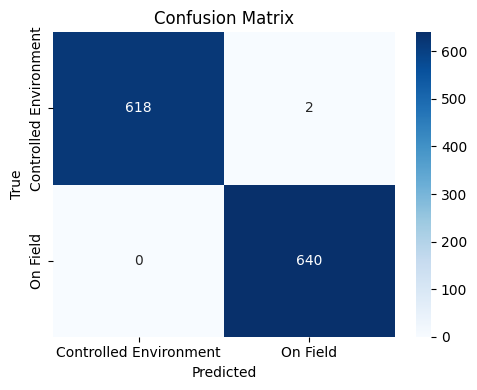

Saved: /kaggle/working/results/EfficientNet_B0_Fro_summary.csv


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Model,Split,FreezeFeatures,Accuracy,Precision,Recall,F1,ROC_AUC,GFLOPs,Params_M,TrainTime_sec,TestTime_sec
0,EfficientNet_B0_Fro,30:70,True,99.84,0.9984,0.9984,0.9984,NaN,0.414,4.01,4518.65,373.76


In [4]:
all_results = []

# load base dataset once (to get class names and n_total)
base_dataset = datasets.ImageFolder(DATA_DIR, transform=data_transforms["val"])
class_names = base_dataset.classes
n_total     = len(base_dataset)

print("Total images:", n_total)
print("Classes:", class_names)

# which ratios to run
if USE_SINGLE_RATIO:
    ratios_to_run = [TRAIN_RATIO]
else:
    ratios_to_run = DEFAULT_RATIOS

for ratio in ratios_to_run:
    print("\n" + "="*60)
    print(f"▶️  Running split {int(ratio*100)} : {int((1-ratio)*100)}")
    print("="*60)

    # ---- split
    train_idx, val_idx, test_idx = get_split_indices(n_total, ratio)

    train_ds = torch.utils.data.Subset(
        datasets.ImageFolder(DATA_DIR, transform=data_transforms["train"]),
        train_idx
    )
    val_ds = torch.utils.data.Subset(
        datasets.ImageFolder(DATA_DIR, transform=data_transforms["val"]),
        val_idx
    )
    test_ds = torch.utils.data.Subset(
        datasets.ImageFolder(DATA_DIR, transform=data_transforms["val"]),
        test_idx
    )

    dataloaders = {
        "train": DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2),
        "val":   DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2),
        "test":  DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2),
    }

    # ---- model
    model = build_model(num_classes=len(class_names), freeze_features=FREEZE_FEATURES)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    # ---- train
    model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=EPOCHS)

    # ---- test
    t0 = time.time()
    acc, prec, rec, f1, roc_auc = evaluate_model(model, dataloaders["test"], class_names)
    test_time = time.time() - t0

    # ---- GFLOPs (directly here; no separate cell)
    gflops, params_m = compute_gflops(copy.deepcopy(model).to(DEVICE), INPUT_SIZE)

    # ---- plot curve & save
    plt.figure(figsize=(6, 4))
    plt.plot(history["train_acc"], label="train_acc")
    plt.plot(history["val_acc"],   label="val_acc")
    plt.title(f"{MODEL_NAME} Acc Curve ({int(ratio*100)}:{int((1-ratio)*100)})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{SAVE_DIR}/curve_{MODEL_NAME}_{int(ratio*100)}.png")
    plt.close()

    # ---- save model checkpoint
    torch.save(model.state_dict(), f"{SAVE_DIR}/{MODEL_NAME}_{int(ratio*100)}.pth")

    # ---- collect result row
    row = {
        "Model": MODEL_NAME,
        "Split": f"{int(ratio*100)}:{int((1-ratio)*100)}",
        "FreezeFeatures": FREEZE_FEATURES,
        "Accuracy": round(acc * 100, 2),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1": round(f1, 4),
        "ROC_AUC": round(roc_auc, 4) if not math.isnan(roc_auc) else np.nan,
        "GFLOPs": None if np.isnan(gflops) else round(gflops, 3),
        "Params_M": None if np.isnan(params_m) else round(params_m, 3),
        "TrainTime_sec": round(history["time"], 2),
        "TestTime_sec": round(test_time, 2),
    }
    all_results.append(row)

# ---- save final CSV
df = pd.DataFrame(all_results)
csv_path = f"{SAVE_DIR}/{MODEL_NAME}_summary.csv"
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)
df